In [1]:
import nltk
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn

# Part 1 : shaping data

In [2]:
#nltk.download('brown')

In [3]:
#We first fix the seed to be sure that the test set is always the same
np.random.seed(1)
torch.manual_seed(1)

In [4]:
#importing the brown corpus from nltk
tagged_sent = nltk.corpus.brown.tagged_sents()

Useful functions

In [5]:
def reshape_data(corpus):
    #data must be in a list as follow : [(sentence,tags),(sentence, tags)...]
    data_set=[]
    for sentence in corpus :
        words = [w[0] for w in sentence]
        tags = [w[1] for w in sentence]
        data_set.append((words,tags))
    return(data_set)

def split_data(corpus,train_length,val_length,test_length) :
    if train_length+val_length+test_length <= len(corpus) :
        training_set = corpus[:train_length]
        validaiton_set = corpus[train_length:train_length+val_length]
        test_set = corpus[train_length+val_length:train_length+val_length+test_length]
        return(training_set,validaiton_set,test_set)
    else:
        return('not enough sentences in the dataset')

def prepare_sequence(seq, to_ix):
    #turn the words of a sentence into its word dictionary index
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

def long_sentences(corpus,n_sent,n_words) :
    """return n_sent sentences with more than n_words"""
    long_sent = []
    for sentence in corpus :
        if len(sentence[0])>n_words :
            long_sent.append(sentence)
    if len(long_sent)>=n_sent :
        return(long_sent[:n_sent])
    else :
        print("not enough long sentences")
        return(long_sent)
    
def short_sentences(corpus,n_sent,n_words) :
    """return n_sent sentences with less than n_words"""
    short_sent = []
    for sentence in corpus :
        if len(sentence[0])<n_words :
            short_sent.append(sentence)
    if len(short_sent)>=n_sent :
        return(short_sent[:n_sent])
    else :
        print("not enough short sentences")
        return(short_sent)

Creating the sets

In [6]:
data_set = reshape_data(tagged_sent)
#shuffle the data_set to be sure sentences are of random lengths
np.random.shuffle(data_set)

#make the training, validation and test set
train_l = 5000
val_l = 2000
test_l = 1000
total = train_l+val_l+test_l

training_set,validation_set,test_set = split_data(data_set,train_l,val_l,test_l)

#add a test set with short sentences (less than 5 words)
short_test_set = short_sentences(data_set[total:],test_l,5)
#add a test set with long sentences (more than 40 words)
long_test_set = long_sentences(data_set[total:],test_l,40)

Creating dictionaries

In [7]:
#creates one dictionary of all the tags and an other of all the words in the corpus
word_to_ix = {}
tag_dic ={}
for sent, tags in data_set:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags :
        if tag not in tag_dic :
            tag_dic[tag] = len(tag_dic)

# Part 2 : LSTM architectures

In [8]:
# from http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

#network dimensions
EMBEDDING_DIM = 300
HIDDEN_DIM = 200

In [9]:
class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

In [10]:
class LSTMTagger_bidir(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger_bidir, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        
        self.hidden2tag = nn.Linear(2*hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(2, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(2, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

# Part 3 : training the networks and making predictions

In [11]:
def training_net(training_set,model) :
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    #shuffle the data at before each training loop
    np.random.shuffle(training_set)
    
    for sentence, tags in training_set:
        #clear the gradient before each instance
        model.zero_grad()
        #clear out the hidden state of the lstm
        #detaching it from its history on the last instance
        model.hidden = model.init_hidden()
        
        #get the inputs ready for the network : turn them into variable of word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_dic)
        
        #forward pass
        tag_scores = model(sentence_in)

        #compute loss, gradient, and update the parameters 
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()


In [12]:
def validation_net(validaiton_set,model) :
    np.random.shuffle(validation_set)
        
    sent_f1score = []
    
    for sentence, tags in validation_set :
        model.zero_grad()
        model.hidden = model.init_hidden()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        
        #making predictions
        _,tags_predictions = torch.max(model(sentence_in), dim=1)

        #computing targets
        targets = prepare_sequence(tags, tag_dic)
        
        #list in wich we store the rigth predictions for the given setence
        sentence_prediction = []
        
        for i in range(len(targets)) :
            #for each word, one if it's the good tag, 0 otherwise
            sentence_prediction.append(int(targets[i]==tags_predictions[i]))
            
        #computing f1 score over the validation set
        array_target = targets.data.numpy()
        array_pred = tags_predictions.data.numpy()
        sent_f1score.append(sklearn.metrics.f1_score(array_target,array_pred,average='micro'))
                                                     
    return(np.average(sent_f1score))

In [13]:
def test_net(test_set,model): 
    test_sent_f1score = []
    for sentence, tags in test_set :
        model.zero_grad()
        model.hidden = model.init_hidden()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        #making predictions
        _,tags_predictions = torch.max(model(sentence_in), dim=1)

        #computing f1 score
        targets = prepare_sequence(tags, tag_dic)
        
        sentence_prediction = []
        
        for i in range(len(targets)) :
            #for each word, one if it's the good tag, 0 otherwise
            sentence_prediction.append(int(targets[i]==tags_predictions[i]))
            
        #convert tags and predictions to the numpy array
        array_target = targets.data.numpy()
        array_pred = tags_predictions.data.numpy()
        #store the f1 score of each sentence
        test_sent_f1score.append(sklearn.metrics.f1_score(array_target,array_pred,average='micro'))
        
    return(np.average(test_sent_f1score))

Simple LSTM

f1 score computed on the test set with a LSTM
0.8224025491498994
f1 score computed on the test set with a LSTM, with short sentences
0.538
f1 score computed on the test set with a LSTM, with long sentences
0.8418865061387069


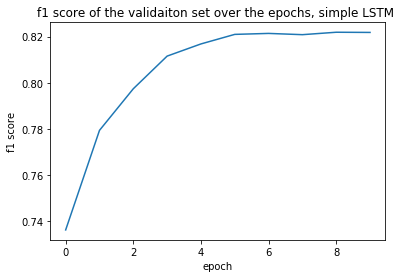

In [14]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))

loss = 0 #initialize the loss for the training_net function
validation_f1score = [] #lost of all the f1 score computed on the validation set

for epoch in range(10) :
    training_net(training_set,model)
    epoch_score = validation_net(validation_set,model)
    validation_f1score.append(epoch_score)
    
#printing the results :
plt.plot(validation_f1score)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.title('f1 score of the validaiton set over the epochs, simple LSTM ')
#plt.savefig("f1_score_lstm_v3.pdf")

test_score = test_net(test_set,model)
print('f1 score computed on the test set with a LSTM')
print(test_score)

test_score_short = test_net(short_test_set,model)
print('f1 score computed on the test set with a LSTM, with short sentences')
print(test_score_short)

test_score_long = test_net(long_test_set,model)
print('f1 score computed on the test set with a LSTM, with long sentences')
print(test_score_long)

bidirectional lstm

f1 score computed on the test set with a bidir LSTM
0.8455889070418845
f1 score computed on the test set with a bidir LSTM, with short sentences
0.5848333333333332
f1 score computed on the test set with a bidir LSTM, with long sentences
0.8690353366414832


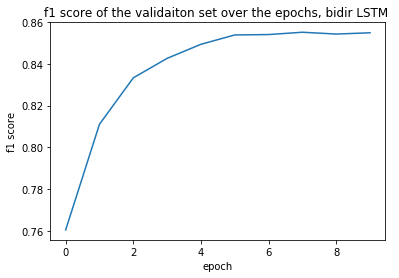

In [15]:
model_bi = LSTMTagger_bidir(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))

loss = 0 #initialize the loss for the training_net function
validation_f1score = [] #lost of all the f1 score computed on the validation set

for epoch in range(10) :
    training_net(training_set,model_bi)
    epoch_score = validation_net(validation_set,model_bi)
    validation_f1score.append(epoch_score)
    
#printing the results :
plt.plot(validation_f1score)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.title('f1 score of the validaiton set over the epochs, bidir LSTM ')
#plt.savefig("f1_score_bilstm_v3.pdf")

test_score_bi = test_net(test_set,model_bi)
print('f1 score computed on the test set with a bidir LSTM')
print(test_score_bi)

test_score_short_bi = test_net(short_test_set,model_bi)
print('f1 score computed on the test set with a bidir LSTM, with short sentences')
print(test_score_short_bi)

test_score_long_bi = test_net(long_test_set,model_bi)
print('f1 score computed on the test set with a bidir LSTM, with long sentences')
print(test_score_long_bi)